# AML Group Assignment 3

***

This assignment focuses on the Neural Networks application in image classification using the Fashion_MNIST dataset, which includes a set of 28x28 grayscale images, each associated with one of 10 labels. We start by creating a bencmark model, kernelised SVM, then proceed to create and tune the hyperparameters of a Neural Network. Finally, we run and explore a version of the convolutional neural network.

***

<br/>


<div style="border-top: 3px solid gray;"></div>

### <span style= "color: navy"> Import Libraries

In [2]:
#Loading required packages
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from numpy import matrix
import numpy as np

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten


***

### <span style= "color: navy"> Data and Pre-processing

<br>

### Read Data


Train: X=(45000, 28, 28), y=(45000,)

Validation: X=(15000, 28, 28), y=(15000,)

Test: X=(10000, 28, 28), y=(10000,)


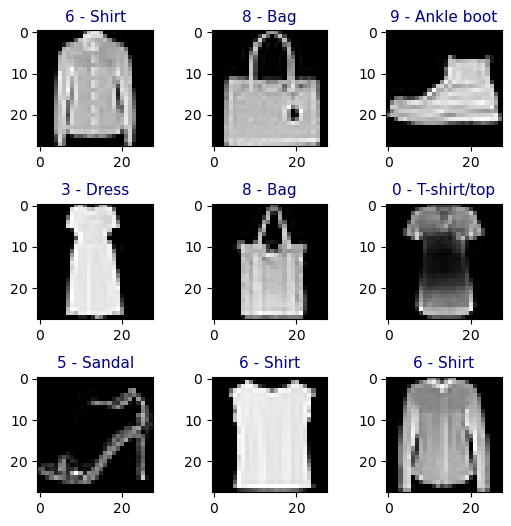

In [3]:
#Loading the data
(X_train_orig, y_train_orig), (X_test, y_test) = fashion_mnist.load_data()
#Splitting the train set into validation samples (25%)
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.25, random_state=42)

#Define labels
labels = {
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot'}


# Summarize loaded dataset
print('\nTrain: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('\nValidation: X=%s, y=%s' % (X_val.shape, y_val.shape))
print('\nTest: X=%s, y=%s' % (X_test.shape, y_test.shape))

# Plot first few images
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    # Plot raw pixel data
    ax.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    # Add title
    ax.set_title(str(y_train[i]) + ' - ' + labels[y_train[i]], size=11, color="navy")

# Show the figure
plt.show()

<br>

### Normalize the pixel to range 0-1

In [4]:
X_train = X_train.astype('float32')/255.0 #45K observations
X_val = X_val .astype('float32')/255.0 #15K observations
X_train_orig = X_train_orig.astype('float32')/255.0 #60K observations; before train-val split
X_test = X_test.astype('float32')/255.0

<br>

### Flatten Pixels for SVM
The data is two-dimensional (28x28 pixels). Therefore, it needs to be flattened as SVM can only handle one-dimensional input data. The default order 'C' will be used, which means that the function moves row by row, where it transposes the row into a column vector, then moves to the next row to do the same. 

In [5]:
# X_train_flattened = matrix.flatten(X_train, order = 'C')
# X_val_flattened = matrix.flatten(X_val, order = 'C')
# X_test_flattened = matrix.flatten(X_test, order = 'C')

X_train_flattened = np.array([image.flatten(order='C') for image in X_train])
X_val_flattened = np.array([image.flatten(order='C') for image in X_val])
X_test_flattened = np.array([image.flatten(order='C') for image in X_test])



In [6]:
print("Train Data Check: ",X_train_flattened.shape[1] == X_train.shape[1]*X_train.shape[2])

print("Validation Data Check: ",X_val_flattened.shape[1] == X_val.shape[1]*X_val.shape[2])

print("Test Data Check: ",X_test_flattened.shape[1] == X_test.shape[1]*X_test.shape[2])

Train Data Check:  True
Validation Data Check:  True
Test Data Check:  True



<div style="border-top: 3px solid gray;"></div>

## <span style = "color:#0037A4"> (a) Implement Kernelised SVM
<br>
    
includes tuning of regularization parameter C and the kernel used {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}    

In [6]:
# use X_train_flattened, X_val_flattened, X_test_flattened`

In [7]:
X_train_flattened.shape[0]

45000

In [8]:
y_train.shape

(45000,)

In [9]:
X_train.shape[0]

45000

In [10]:
X_train_flattened.reshape(-1, 1)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
# Define alpha space to test
C_space = np.logspace(-2,1,21)

# Initialize empty lists to store misclassification errors
svm_train_acc = []
svm_val_acc = []

# Traning the model and measure performance for each alpha
for C in C_space:
    SVM = SVC(C=C, kernel='rbf',random_state = 0)
    SVM.fit(X_train_flattened, y_train)
    svm_train_acc.append(1-accuracy_score(y_train, SVM.predict(X_train_flattened)))
    svm_val_acc.append(1-accuracy_score(y_val, SVM.predict(X_val_flattened)))

<div style="border-top: 3px solid gray;"></div>

## <span style = "color:#0037A4"> (b) Implement a Fully-Connected Neural Network
<br>
    
    
Neural Networks are a class of machine learning inspired by the human brain function, where a neural network consists of layers of artificial neurons/nodes connected to each other. These layers consist of an input layer (input features) which are the image pixels in this case, one or multiple hidden layers, and an output layer consisting of K nodes where K is number of labels of a categorical variable. In this case, K = 10 which is the number of fashion item labels available in the data. The output layer nodes each hold the probability of the sample belonging to the label k (probabilities $Y_1, \dots, Y_K$).
    
The input features are passed through the network layers where a set of linear functions (weights and biases) are estimated and passed through activation functions that transform the them to capture non-linear complex relationships to finally estimate the probability of each observation being classified to each of the output categories.       
    
To fit a fully connected neural network, we start by defining the network layers. First, defining the input layer by flatenning the 28x28 pixel image input. This is followed by defining two hidden layers, one with 12 neurons and the other with 8 neurons similar to the activity in session 6.5. Both layers are defined to use the relu activation function: $r(v) = max(0,v)$. The final layer defined is the output layer consisting of 10 neurons representing the 10 fashion labels. 
    
The neural network works to minimise the error between the predicted output and the actual output label through a backpropagation optimisation process. Therefore, the second step to define the model is to define the optimizer to be used and the error measure to minimise. In this case, the error measure is cross-entropy due to the classification nature of the problem, specifically the sparse categorical cross-entropy is used to since the output labels were not transformed to one-hot-encoding which would have allowed the use of categorical cross-entopy. 
    
Finally, the model is fit using the hyper-parameters epochs = 150 and batch size = 10 as was defined in the activity in session 6.5. Epochs is basically the number of iterations the fitting process will go through. It is considered to be one of the hyper-parameters of Neural Networks where a to few Epochs may lead to underfitting while a too high value could lead to overfitting to the training data. Batch size, another hyper-parameter, indicates the number of sample points that will be used during each iteration to update the estimates of the weights (coefficients). The batch size would be the sample size used to calculate the gradient of the loss function to update the model's paramaters.     

In [20]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28))) 
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax')) #output - 10 labels

In [22]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy']) #uses sparse_categorical_crossentropy since the output labels were not transformed to one-hot-encoding

In [23]:
model1_callback = model.fit(X_train_orig, y_train_orig, epochs=10, batch_size=10, verbose = False)

In [10]:
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))


313/313 [==============================] - 0s 791us/step - loss: 0.4573 - accuracy: 0.8430
Accuracy: 84.30


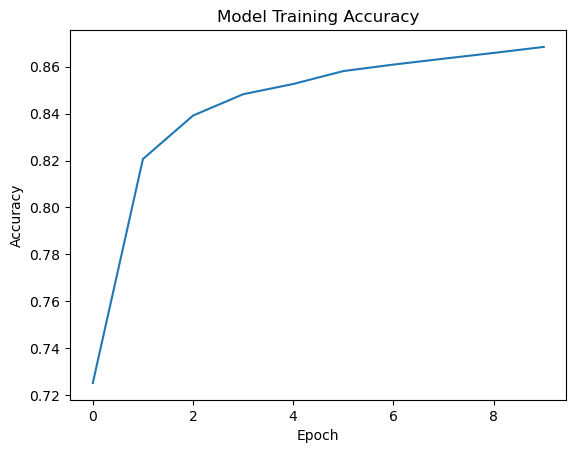

In [11]:
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

<br>

**Comment on Accuracy of Train vs Test + Train Accuracy convergence versus Epoch**

<div style="border-top: 3px solid gray;"></div>

## <span style = "color:#0037A4"> (c) Neural Network Hyper-parameter Tuning  
<br>
    

### Add one more layer between the 12-neuron layer and the input layer; decide the numbers of neurons on that layer on your own.

We will build a new model, called "model_2". There are several ways to get an intuition on the number of hidden layers required in a given problem and the number of neurons for each layer. For this example, we will use common practice heuristics and validate these changes with the training-validation split approach. We will leverage the built-in validation_split argument of the compile function to pass a 25% split of the traning data for validation. Then, we will compare the validation accuracies of the original model, i,e: the one trained in b with the new models we are developing to see if there were improvements. We will also use the test validation approach to decide between different numbers of layers.

In [42]:
epochs = 150
val_split = 0.25

# Fitting model 1 again with the fixed number of epochs, 
model1_callback = model.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                            epochs=epochs, batch_size=10, verbose = False)


#Declaring model 2
model_2 = Sequential()
model_2.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(12, activation='relu'))
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model2_callback = model_2.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                              epochs=epochs, batch_size=10, verbose = False)

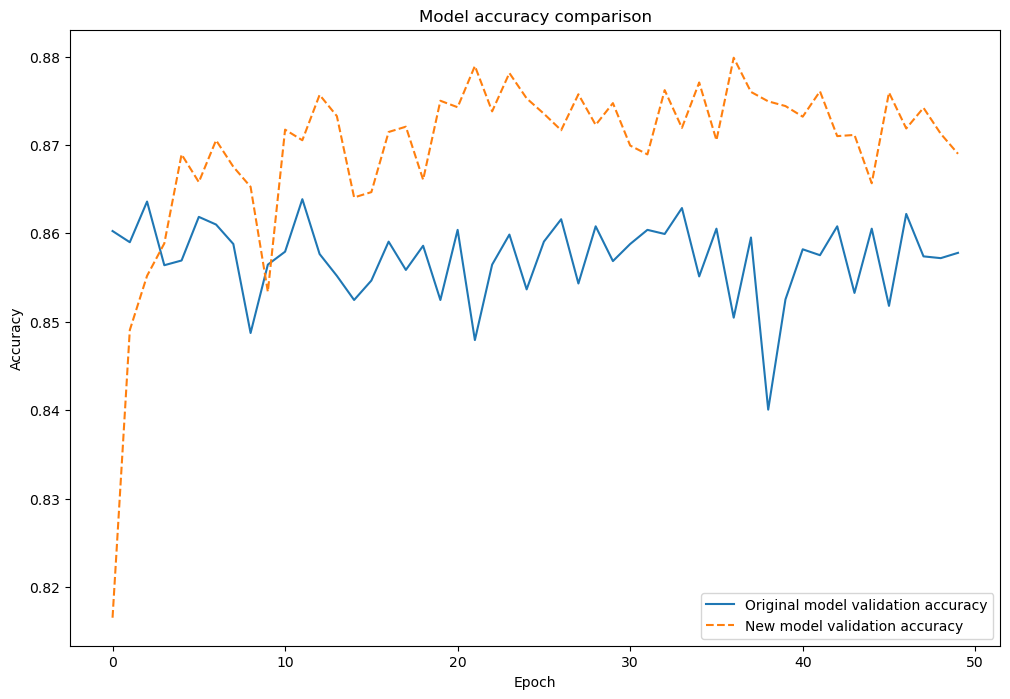

In [50]:
#Plotting the accuracy comparison on the validation split
fig = plt.figure(figsize=(12,8))

plt.plot(model1_callback.history['val_accuracy'], label='Original model validation accuracy')
plt.plot(model2_callback.history['val_accuracy'], linestyle='--', label='New model validation accuracy')
plt.title('Model accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

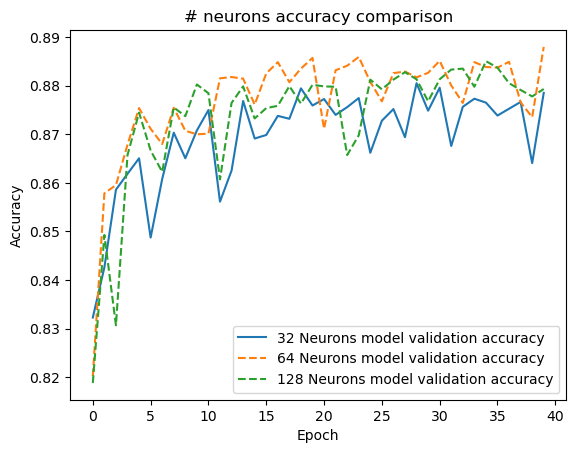

In [47]:
epochs = 150

#Declaring model 2
model_32 = Sequential()
model_32.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_32.add(Dense(32, activation='relu'))
model_32.add(Dense(12, activation='relu'))
model_32.add(Dense(8, activation='relu'))
model_32.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_32.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model32_callback = model_32.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                              epochs=epochs, batch_size=10, verbose = False)

model_64 = Sequential()
model_64.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_64.add(Dense(64, activation='relu'))
model_64.add(Dense(12, activation='relu'))
model_64.add(Dense(8, activation='relu'))
model_64.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_64.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model64_callback = model_64.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                              epochs=epochs, batch_size=10, verbose = False)

model_128 = Sequential()
model_128.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_128.add(Dense(64, activation='relu'))
model_128.add(Dense(12, activation='relu'))
model_128.add(Dense(8, activation='relu'))
model_128.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_128.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model128_callback = model_128.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                              epochs=epochs, batch_size=10, verbose = False)

plt.plot(model32_callback.history['val_accuracy'], label='32 Neurons model validation accuracy')
plt.plot(model64_callback.history['val_accuracy'], linestyle='--', label='64 Neurons model validation accuracy')
plt.plot(model128_callback.history['val_accuracy'], linestyle='--', label='128 Neurons model validation accuracy')
plt.title('# neurons accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

It seems that for 10 epochs, we incresed the accuracy of the model by adding a hidden layer with 32 neurons. Adding layers does not guarantee an increase in the performance, but in many cases it does. 

In [71]:
_, accuracy32 = model_32.evaluate(X_test, y_test)
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy of the new model: %.2f' % (accuracy32*100))
print('Accuracy of the previous model: %.2f' % (accuracy*100))

313/313 [==============================] - 0s 752us/step - loss: 0.7594 - accuracy: 0.8383
Accuracy of the new model: 87.22
Accuracy of the previous model: 83.83


### Change the numbers of the neurons (12 and 8) to other values.

Next, we will change the combinations of number of neuros per hidden layer. 

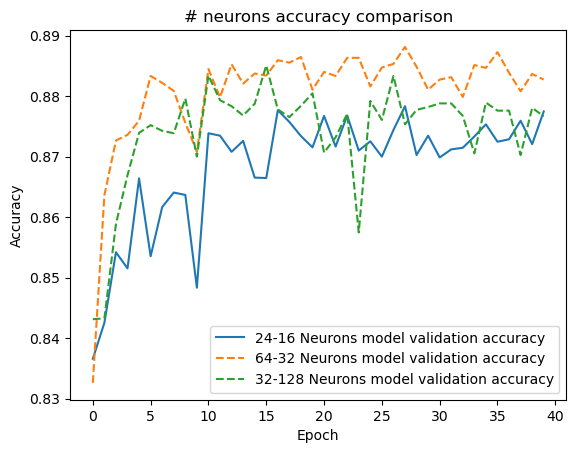

In [52]:
epochs = 150

#Declaring model 2
model_24_16 = Sequential()
model_24_16.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_24_16.add(Dense(24, activation='relu'))
model_24_16.add(Dense(16, activation='relu'))
model_24_16.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_24_16.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model_24_16_callback = model_32.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                              epochs=epochs, batch_size=10, verbose = False)

model_64_32 = Sequential()
model_64_32.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_64_32.add(Dense(64, activation='relu'))
model_64_32.add(Dense(32, activation='relu'))
model_64_32.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_64_32.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model_64_32_callback = model_64.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                              epochs=epochs, batch_size=10, verbose = False)

model_32_128 = Sequential()
model_32_128.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_32_128.add(Dense(32, activation='relu'))
model_32_128.add(Dense(128, activation='relu'))
model_32_128.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_32_128.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model_32_128_callback = model_128.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                              epochs=epochs, batch_size=10, verbose = False)

plt.plot(model_24_16_callback.history['val_accuracy'], label='24-16 Neurons model validation accuracy')
plt.plot(model_64_32_callback.history['val_accuracy'], linestyle='--', label='64-32 Neurons model validation accuracy')
plt.plot(model_32_128_callback.history['val_accuracy'], linestyle='--', label='32-128 Neurons model validation accuracy')
plt.title('# neurons accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

We see that the best model is the one with the pairs ['64-32']. Therefore, we will compare it to the original model. We see that tweacking the number of neurons in the hidden layers did in fact produce better accuracy overall.

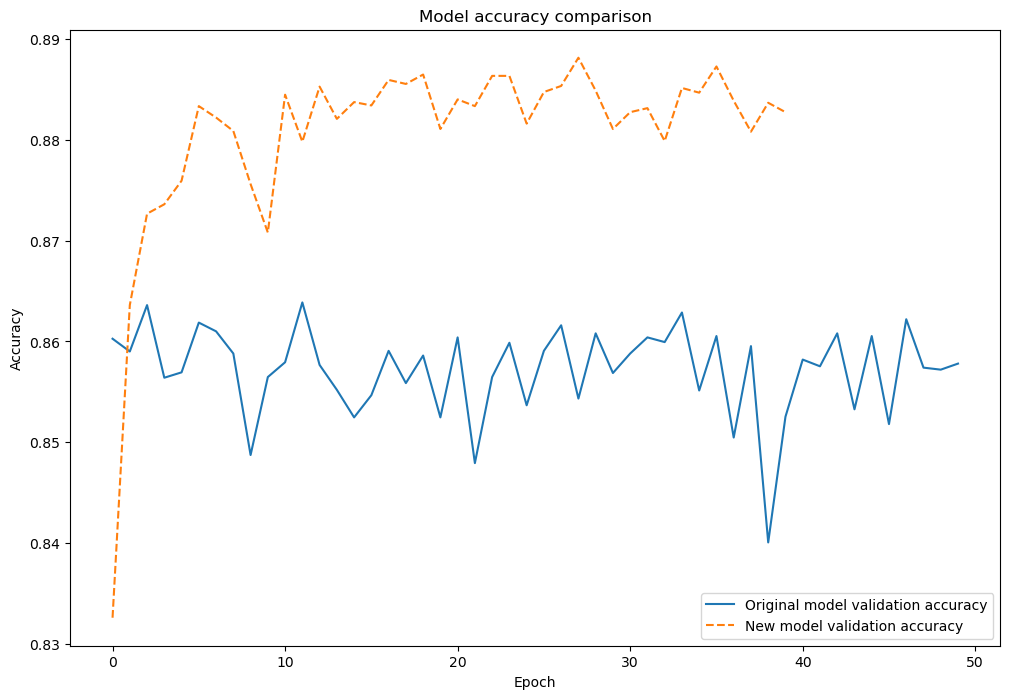

In [53]:
#Plotting the accuracy comparison on the validation split
fig = plt.figure(figsize=(12,8))

plt.plot(model1_callback.history['val_accuracy'], label='Original model validation accuracy')
plt.plot(model64_callback.history['val_accuracy'], linestyle='--', label='New model validation accuracy')
plt.title('Model accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [72]:
_, accuracy_64_32 = model_64_32.evaluate(X_test, y_test)
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy of the new model: %.2f' % (accuracy_64_32*100))
print('Accuracy of the previous model: %.2f' % (accuracy*100))

NameError: name 'model_64_32' is not defined

### Change the loss function (through the loss in the compile function).

We will now use our data with the y vector being One-hot encoded. That way, we can apply binary crossentropy as the loss function

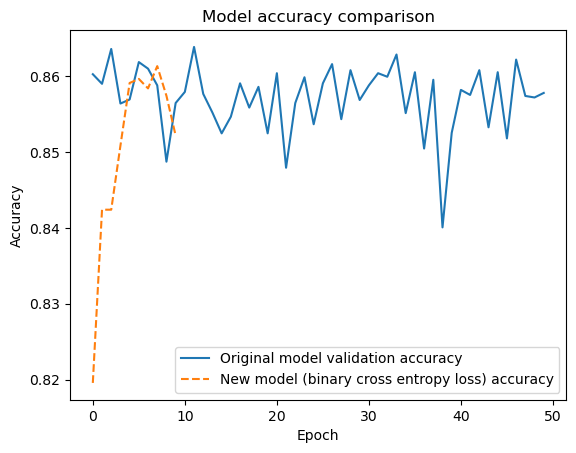

In [60]:
epochs = 150

from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, 10)
y_val_one_hot = to_categorical(y_val, 10)

#Declaring model 4 as a replica of the original model

model_bin = Sequential()
model_bin.add(Flatten(input_shape=(28, 28))) 
# Changing number of neurons of the hidden layers
model_bin.add(Dense(16, activation='relu'))
model_bin.add(Dense(10, activation='sigmoid')) #output - 10 labels

model_bin.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

model_bin_callback = model_bin.fit(X_train, y_train_one_hot, validation_split=val_split, epochs=epochs, batch_size=10, verbose=False)


plt.plot(model1_callback.history['val_accuracy'], label='Original model validation accuracy')
plt.plot(model_bin_callback.history['val_accuracy'], linestyle='--', label='New model (binary cross entropy loss) accuracy')
plt.title('Model accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

### Change the epochs and batch_size in the fit function.

We start by changing the batch size of the functions. It seems that increasing the batch sizes is not producing better results for the validation set. Therefore, we remain at 10.

Epoch 1/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.3249 - accuracy: 0.8860 - val_loss: 0.3127 - val_accuracy: 0.8898
Epoch 2/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.3165 - accuracy: 0.8860 - val_loss: 0.3219 - val_accuracy: 0.8831
Epoch 3/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.3118 - accuracy: 0.8880 - val_loss: 0.3266 - val_accuracy: 0.8841
Epoch 4/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.3082 - accuracy: 0.8879 - val_loss: 0.3288 - val_accuracy: 0.8831
Epoch 5/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.3071 - accuracy: 0.8886 - val_loss: 0.3229 - val_accuracy: 0.8848
Epoch 6/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.3031 - accuracy: 0.8891 - val_loss: 0.3341 - val_accuracy: 0.8823
Epoch 7/10
4500/4500 [==============================] - 5s 1ms/step - loss: 0.3029 - accuracy: 0.8889 - val_loss: 0.3391 - val_accuracy:

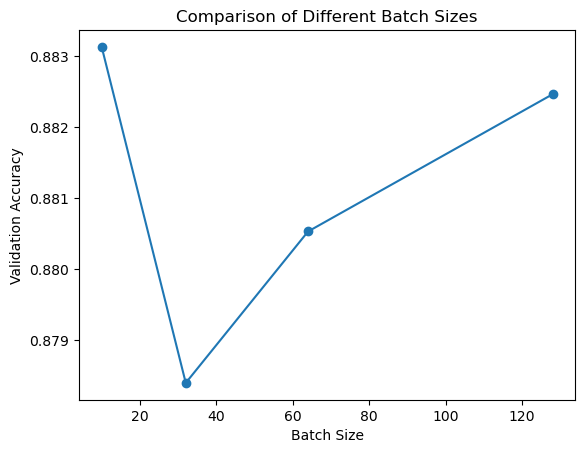

In [61]:
#Declaring different batch sizes
batch_sizes = [10, 32, 64, 128]

results= []

for batch_size in batch_sizes:
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
    results.append(model.evaluate(X_val, y_val, batch_size=batch_size))

for i, batch_size in enumerate(batch_sizes):
    print(f"Batch Size: {batch_size}, Validation Accuracy: {results[i][1]}, Validation Loss: {results[i][0]}")
    
plt.plot(batch_sizes, [result[1] for result in results], marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Different Batch Sizes')
plt.show()

As for the number of Epochs, there are several approaches to testing this. We could set pre-defined values for epochs but we can also use the Early stop function from the Keras package, that way, we can observe when the model converges (that is, accuracy stops improving).

Epoch 1/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2386 - accuracy: 0.9126 - val_loss: 0.4106 - val_accuracy: 0.8696
Epoch 2/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2374 - accuracy: 0.9121 - val_loss: 0.4144 - val_accuracy: 0.8694
Epoch 3/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2343 - accuracy: 0.9140 - val_loss: 0.4074 - val_accuracy: 0.8686
Epoch 4/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2357 - accuracy: 0.9136 - val_loss: 0.3974 - val_accuracy: 0.8750
Epoch 5/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2351 - accuracy: 0.9139 - val_loss: 0.4106 - val_accuracy: 0.8708
Epoch 6/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2363 - accuracy: 0.9128 - val_loss: 0.4279 - val_accuracy: 0.8661
Epoch 7/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2355 - accuracy: 0.9138 - val_loss: 0.4180 - val_ac

1055/1055 [==============================] - 1s 1ms/step - loss: 0.2256 - accuracy: 0.9174 - val_loss: 0.4734 - val_accuracy: 0.8638
Epoch 58/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2246 - accuracy: 0.9182 - val_loss: 0.4746 - val_accuracy: 0.8667
Epoch 59/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2266 - accuracy: 0.9167 - val_loss: 0.4573 - val_accuracy: 0.8663
Epoch 60/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2239 - accuracy: 0.9176 - val_loss: 0.4785 - val_accuracy: 0.8623
Epoch 61/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2249 - accuracy: 0.9167 - val_loss: 0.4835 - val_accuracy: 0.8612
Epoch 62/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2227 - accuracy: 0.9185 - val_loss: 0.4598 - val_accuracy: 0.8685
Epoch 63/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2278 - accuracy: 0.9165 - val_loss: 0.4675 - val_accuracy

1055/1055 [==============================] - 1s 1ms/step - loss: 0.2163 - accuracy: 0.9206 - val_loss: 0.5251 - val_accuracy: 0.8629
Epoch 114/150
1055/1055 [==============================] - 2s 1ms/step - loss: 0.2195 - accuracy: 0.9209 - val_loss: 0.5344 - val_accuracy: 0.8604
Epoch 115/150
1055/1055 [==============================] - 2s 1ms/step - loss: 0.2160 - accuracy: 0.9218 - val_loss: 0.5411 - val_accuracy: 0.8627
Epoch 116/150
1055/1055 [==============================] - 2s 1ms/step - loss: 0.2155 - accuracy: 0.9216 - val_loss: 0.5518 - val_accuracy: 0.8620
Epoch 117/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2174 - accuracy: 0.9206 - val_loss: 0.5229 - val_accuracy: 0.8611
Epoch 118/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2149 - accuracy: 0.9212 - val_loss: 0.5403 - val_accuracy: 0.8631
Epoch 119/150
1055/1055 [==============================] - 1s 1ms/step - loss: 0.2177 - accuracy: 0.9202 - val_loss: 0.5237 - val_ac

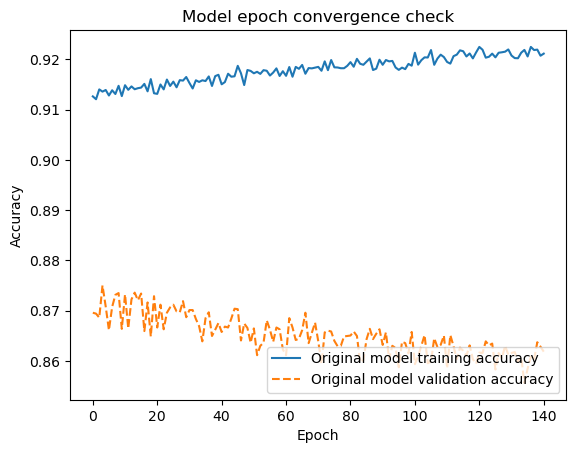

In [69]:
# Import the early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

# Define a callback to monitor val_accuracy
monitor_val_acc = EarlyStopping(monitor='accuracy', 
                       patience=20)

# Train your model using the early stopping callback
model_callback = model.fit(X_train, y_train, epochs=150, validation_split=val_split, 
                           callbacks= [monitor_val_acc])

plt.plot(model_callback.history['accuracy'], label='Original model training accuracy')
plt.plot(model_callback.history['val_accuracy'], linestyle='--', label='Original model validation accuracy')
plt.title('Model epoch convergence check')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [64]:
help(EarlyStopping)

Help on class EarlyStopping in module keras.src.callbacks:

class EarlyStopping(Callback)
 |  EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0)
 |  
 |  Stop training when a monitored metric has stopped improving.
 |  
 |  Assuming the goal of a training is to minimize the loss. With this, the
 |  metric to be monitored would be `'loss'`, and mode would be `'min'`. A
 |  `model.fit()` training loop will check at end of every epoch whether
 |  the loss is no longer decreasing, considering the `min_delta` and
 |  `patience` if applicable. Once it's found no longer decreasing,
 |  `model.stop_training` is marked True and the training terminates.
 |  
 |  The quantity to be monitored needs to be available in `logs` dict.
 |  To make it so, pass the loss or metrics at `model.compile()`.
 |  
 |  Args:
 |    monitor: Quantity to be monitored.
 |    min_delta: Minimum change in the monitored quanti

***

## Best Model


can print some of the predictions similar to what is done here:
https://www.tensorflow.org/tutorials/keras/classification

<div style="border-top: 3px solid gray;"></div>

## <span style = "color:#0037A4"> (d) Convolutional Neural Network (CNN)  
<br>
    